In [77]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import minimize

In [78]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [79]:
# Variáveis para o gráfico
plot_params = {'legend.fontsize': 30,
               'figure.figsize': (20, 10),
               'axes.labelsize':  30,
               'axes.titlesize':  30,
               'xtick.labelsize': 25,
               'ytick.labelsize': 25}

plt.style.use('ggplot')

plt.rcParams.update(plot_params)

color_dark_blue = [1/255, 62/255, 125/255]
color_light_blue = [6/255, 143/255, 203/255]
purple = [102/255, 51/255, 153/255]

color = [color_dark_blue, color_light_blue, purple]

# Modelo/Parametrização de SABR

O modelo SABR (Stochastic Alpha Beta Rho) introduzido pode ser descrito da seguinte forma (já na medida neutra ao risco):
$$\left\{\begin{array}{l} 
dS_t = r S_t dt + \sigma_t S_t dW^S_t,\\ 
d\sigma_t =  \xi \sigma_t dW^\sigma_t,
\end{array}\right. $$
onde $W^S$ e $W^\sigma$ são dois movimentos Brownianos em na medida neutra ao risco com $dW^S_t dW^\sigma_t = \rho dt$, $\rho$ constante em $[-1,1]$. Sob esse modelo vale a seguinte aproximação para a volatilidade implícita
$$\hat{\sigma}_t(T,K) \approx \sigma_t \frac{y}{\phi(y)} \left(1 + \left(\frac{1}{4} \rho \xi \sigma_t + \frac{2 - 3\rho^2}{24}\xi^2 \right)\tau \right),$$
onde
\begin{align*}
y = \frac{\xi}{\sigma_t} \log\left(\frac{Se^{r\tau}}{K}\right) \mbox{ e } \phi(y) = \log\left(\frac{\sqrt{1 - 2\rho y + y^2} + y - \rho}{1 - \rho}\right).
\end{align*}

In [80]:
def SABRFormula(S0, T, K, r, params):
    '''
    Função que calcula a volatilidade implícita sob o modelo SABR
    S0 (float > 0) - valor inicial do ativo subjacente
    T (float > 0) - maturidade (em anos)
    K (array > 0) - strikes
    r (float) - taxa de juros livre de risco
    param(dict) - dicionário com as seguintes keys: 'xi', 'sigma0' e 'rho':
        xi (float > 0) - vol-vol
        sigma0 (float > 0) - vol inicial
        rho (float em [-1,1]) - correlação vol-ativo
    '''

    xi = params['xi']
    sigma0 = params['sigma0']
    rho = params['rho']
    
    y = xi/sigma0 * np.log(S0 * np.exp(r*T)/K)

    aux = np.sqrt(1 - 2*rho*y + y**2) + y - rho

    phi = np.log(aux/(1 - rho))

    aux2 = 0.25 * rho * xi * sigma0 + (2 - 3*rho**2)/24 * xi**2

    implied_vols = sigma0 * y / phi * (1 + aux2 * T)
    
    return implied_vols

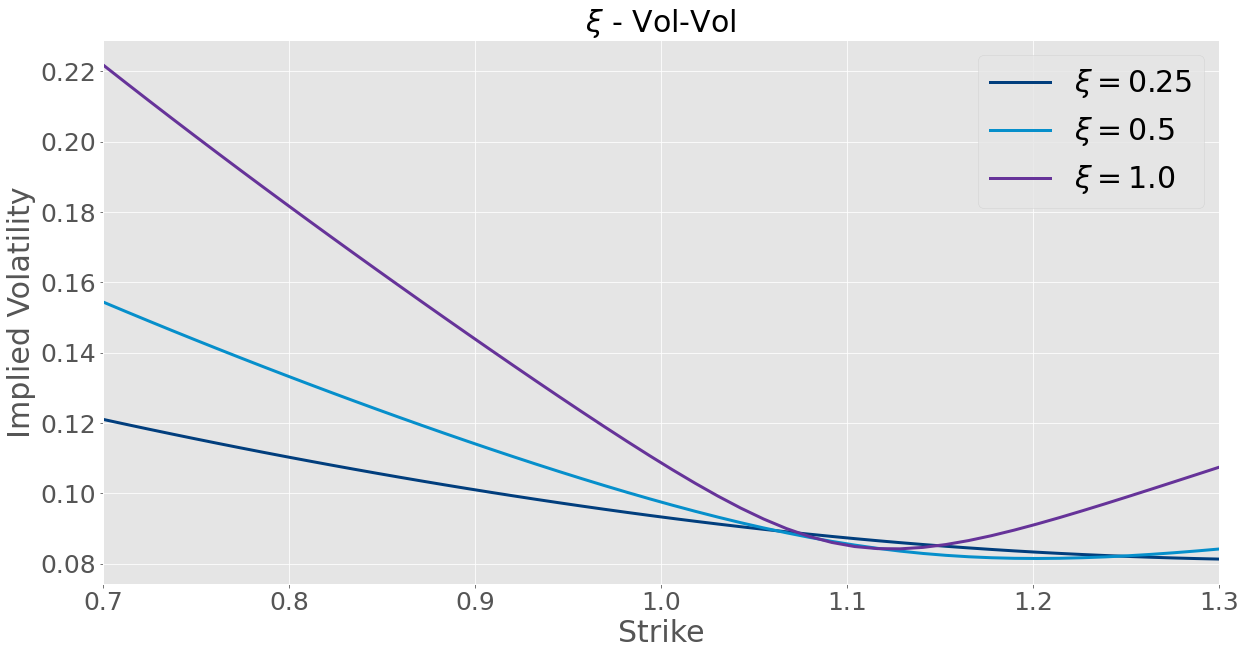

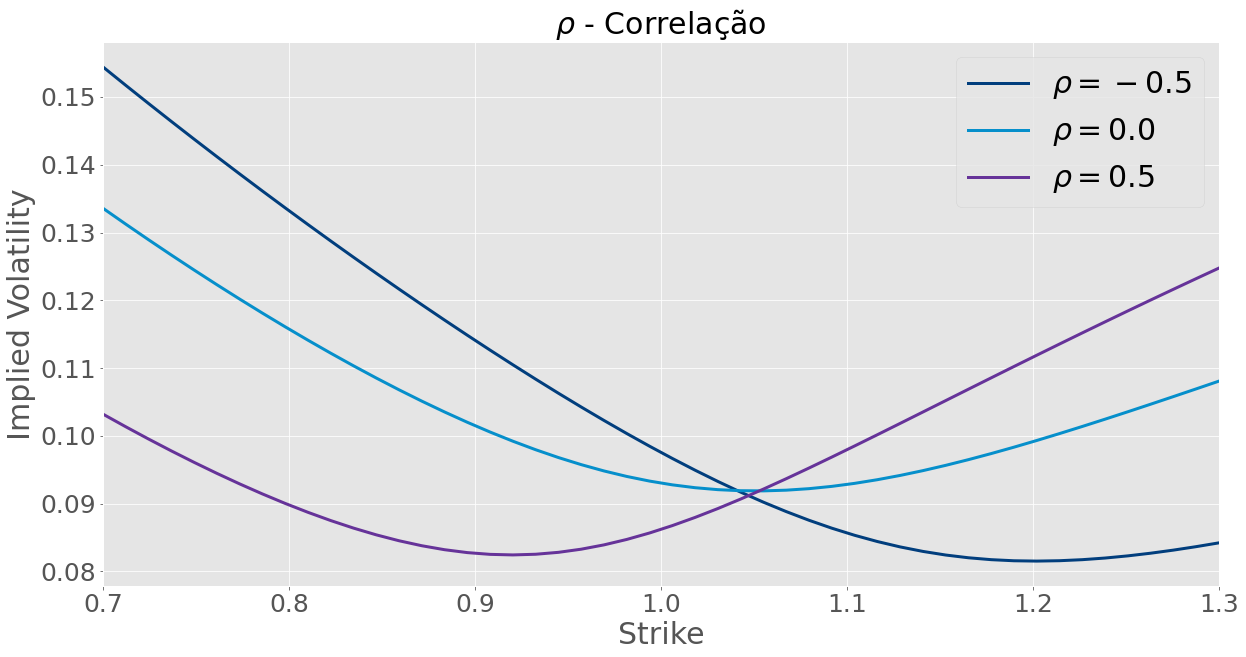

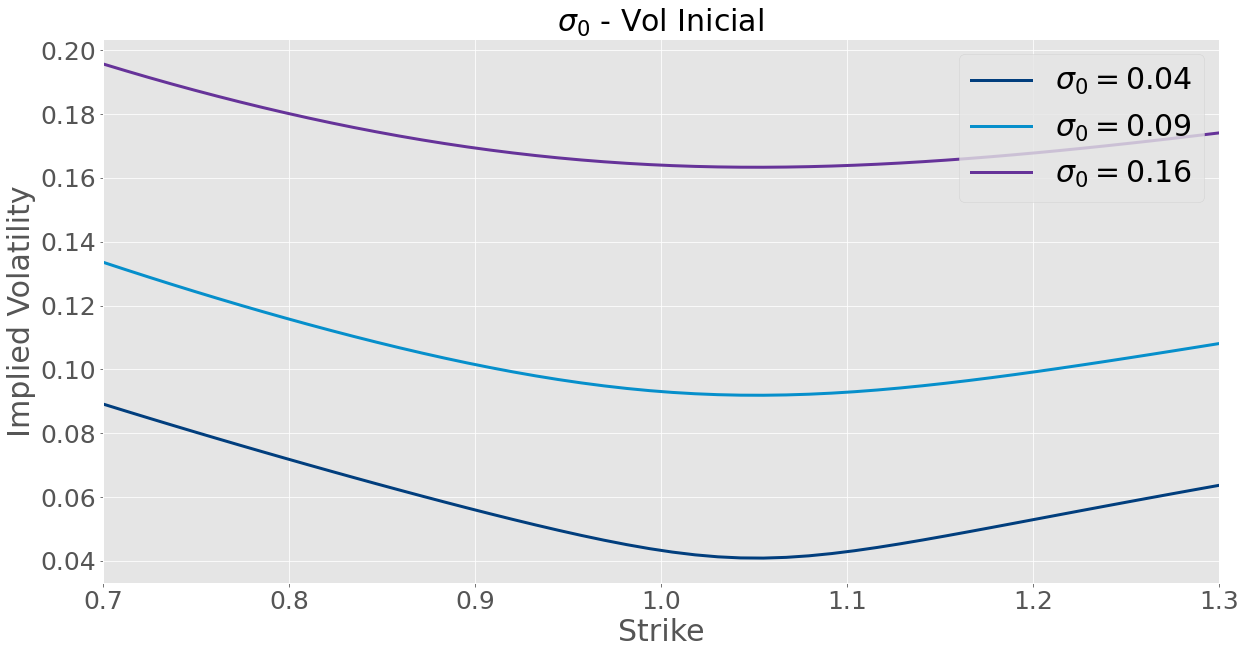

In [81]:
T = 1 #maturidade
S0 = 1 #valor inicial do ativo subjacente
K = S0 * np.linspace(0.7, 1.3, 50) #strikes
r = 0.05 # taxa de juros livre de risco
params =  {'xi': 0.5, 'rho':-0.5, 'sigma0': 0.09} #baseline dos parâmetros

plt.rcParams.update(plot_params)

param_vary = {'xi': [0.25, 0.5, 1.0], 'rho':[-0.5, 0.0, 0.5], 
              'sigma0': [0.04, 0.09, 0.16]} #variação dos parâmetros

tex_param = {'xi': '\\xi', 'rho':'\\rho', 
             'sigma0': '\\sigma_0'} #latex do parâmetros para plot
text_param = {'xi': 'Vol-Vol', 'rho':'Correlação', 
              'sigma0': 'Vol Inicial'} #nome do parâmetros para plot

for param in ['xi', 'rho', 'sigma0']:

    implied_vol_vary = []

    for p in param_vary[param]:

        params[param] = p

        implied_vols = SABRFormula(S0, T, K, r, params)

        implied_vol_vary.append(implied_vols)

    params[param] = param_vary[param][1] #volta com o valor baseline

    plt.figure()    
    for i in [0,1,2]:
        plt.plot(K, implied_vol_vary[i], linewidth=3 ,label=r'$' + tex_param[param]  + ' = ' + str(param_vary[param][i]) + '$', color=color[i])
    plt.xlabel('Strike')
    plt.ylabel('Implied Volatility')
    plt.xlim(K[0], K[-1])
    plt.legend(loc='upper right')
    plt.title(r'$' + tex_param[param] + '$ - ' + text_param[param])

# Calibragem

A calibragem do modelo SABR parametrizado por $\theta = (\xi, \rho, \sigma_0)$ é minimizar a perda
\begin{align*}
L(\theta) &= \sum_{i=1}^M \sum_{j=1}^{N_i} (\hat{\sigma}(T_i,K_{ij};\theta) -  \hat{\sigma}(T_i,K_{ij}))^2,
\end{align*}
onde $\hat{\sigma}(T_i,K_{ij};\theta)$ é a fórmula da volatilidade implícita do modelo SABR e $\hat{\sigma}(T_i,K_{ij})$ é a volatilidade implícita observada no mercado. Aqui, para cada maturidade $T_i$, $i=1,\ldots,M$, temos os strikes $K_{ij}$, com $j=1,\ldots,N_i$.

Um problema anterior ao de minimização da perda $L(\theta)$ descrito acima é escolher quais opções serão usadas na definição de $L$, i.e. a escolha das maturidades $T_1, \ldots, T_M$ e, para cada maturidade $T_i$, dos strikes $K_{i1}, \ldots, K_{iN_i}$. Podemos considerar os seguintes ajustes para remover opções:

$\bullet$ com moneyness abaixo de 90\% e acima de 125\% (outros valores podem ser considerados, dependendo do mercado);

$\bullet$ com volume zero;

$\bullet$ com \textit{open interest} zero;

$\bullet$ com maturidade maior que 1 ano (outro valor pode ser considerado aqui).


In [82]:
option_data = pd.read_excel('SPX_option_data.xlsx')

option_data = option_data[option_data.Open_Int > 0]
option_data = option_data[option_data.Vol > 0]
option_data = option_data[option_data.Bid > 0]
option_data['Moneyness'] = option_data['Strike']/option_data['Underlying_Price']
option_data[['Expiry','Quote_Time']] = option_data[['Expiry','Quote_Time']].apply(pd.to_datetime) 
option_data['Time to maturity'] = (option_data['Expiry'] - option_data['Quote_Time']).dt.days/360
option_data = option_data[option_data['Time to maturity'] >= 0.1]
option_data = option_data[option_data['Time to maturity'] <= 0.7]
option_data = option_data[option_data['Moneyness'] < 1.25]
option_data = option_data[option_data['Moneyness'] > 0.9]
option_data = option_data[option_data['Type'] == 'call']
option_data = option_data[option_data['Root'] == 'SPX']

In [85]:
option_data.head()

,Symbol,Strike,Expiry,Type,Last,Bid,Ask,Chg,PctChg,Vol,...,IV,Root,IsNonstandard,Underlying,Underlying_Price,Quote_Time,Last_Trade_Date,Mid,Moneyness,Time to maturity
4179,SPX200821C02675000,2675,2020-08-21,call,266.20,358.7,360.0,0.0,0.0,10.0,...,0.304927,SPX,True,^SPX,2970.22,2020-05-20 16:29:59,2020-05-15 15:06:44,359.35,0.900607,0.255556
4183,SPX200918C02675000,2675,2020-09-18,call,363.70,375.2,376.3,0.0,0.0,1.0,...,0.298435,SPX,True,^SPX,2970.28,2020-05-20 16:30:00,2020-05-19 17:00:23,375.75,0.900588,0.333333
4187,SPX201016C02675000,2675,2020-10-16,call,370.72,392.5,394.2,0.0,0.0,21.0,...,0.298450,SPX,True,^SPX,2970.37,2020-05-20 16:30:01,2020-05-11 18:58:46,393.35,0.900561,0.411111
4191,SPX201120C02675000,2675,2020-11-20,call,392.17,414.4,416.3,0.0,0.0,21.0,...,0.300361,SPX,True,^SPX,2970.45,2020-05-20 16:30:02,2020-05-11 18:58:46,415.35,0.900537,0.508333
4193,SPX201218C02675000,2675,2020-12-18,call,334.17,426.3,427.9,0.0,0.0,2.0,...,0.295131,SPX,True,^SPX,2970.45,2020-05-20 16:30:02,2020-05-13 18:47:43,427.10,0.900537,0.586111


Text(0.5, 0, 'Volatilidade Implícita')

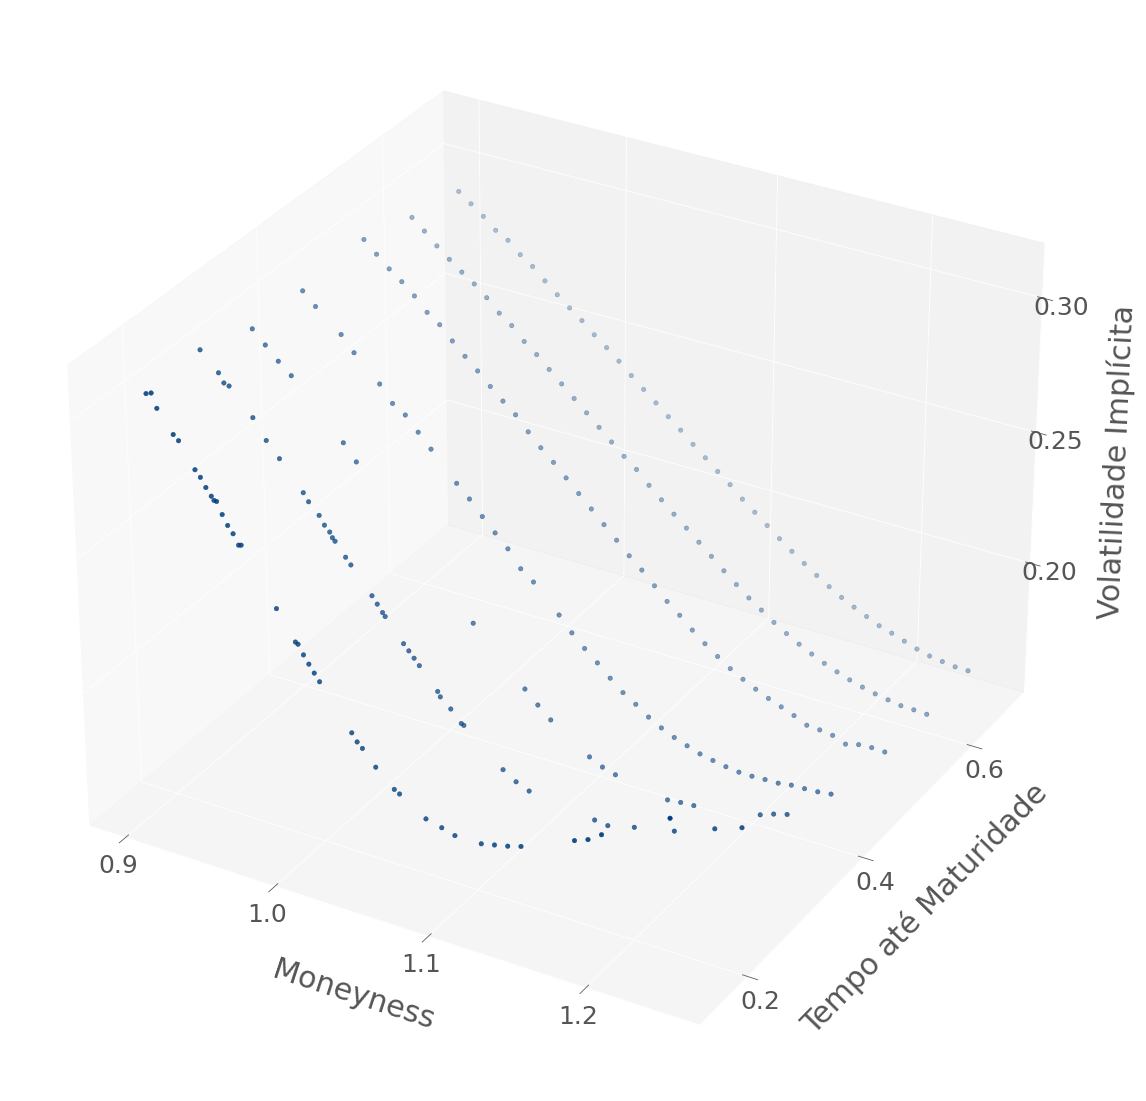

In [86]:
fig = plt.figure(figsize=(30,20))
ax = plt.axes(projection='3d')
plt.locator_params(nbins=5)
ax.set_facecolor('white')
ax.scatter(option_data['Moneyness'].values, option_data['Time to maturity'].values, option_data['IV'].values, c=[color_dark_blue])
ax.yaxis.labelpad=30
ax.xaxis.labelpad=30
ax.zaxis.labelpad=30
ax.set_xlabel('Moneyness')
ax.set_ylabel('Tempo até Maturidade')
ax.set_zlabel('Volatilidade Implícita')

## Calibragem de uma maturidade

In [87]:
option_data_curve = option_data[option_data['Time to maturity'] >= 0.5]
option_data_curve = option_data_curve[option_data_curve['Time to maturity'] <= 0.57]

r = 0.0005
T = option_data_curve['Time to maturity'].values[0]
S0 = option_data_curve['Underlying_Price'].values[0]
K = option_data_curve['Strike'].values
IV = option_data_curve['IV'].values

In [88]:
def loss(params):
    
    params =  {'xi': params[0], 'rho': params[1], 'sigma0': params[2]}
    
    loss = np.mean((SABRFormula(S0, T, K, r, params) - IV)**2)
    
    return loss

param0 = [1.0, -0.5, 0.2]
bounds = [(0.001,None), (-0.99,0.99), (0.001,None)]

res = minimize(loss, x0=param0, bounds=bounds)

In [89]:
res

      fun: 2.6764367323522558e-06
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-2.28599794e-08,  9.82905074e-08, -4.62215715e-08])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 112
      nit: 19
     njev: 28
   status: 0
  success: True
        x: array([ 1.34050323, -0.84903867,  0.25965817])

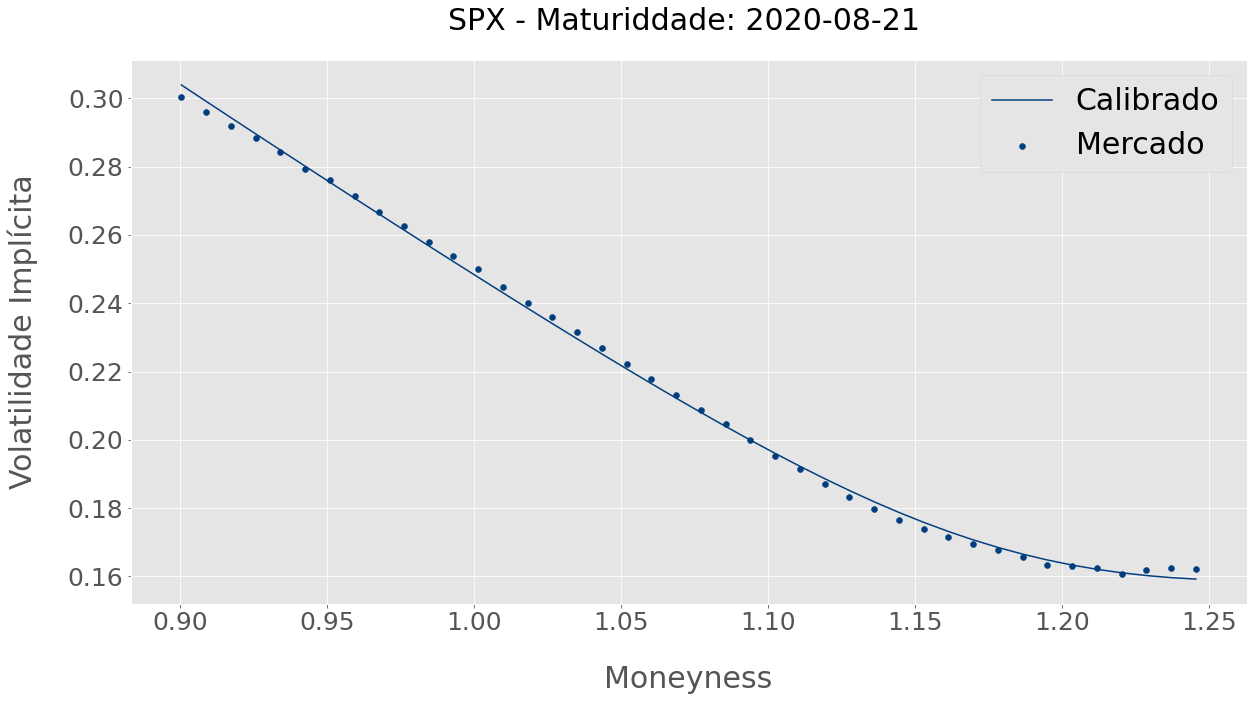

In [90]:
param_calibrated = {'xi': res.x[0], 'rho': res.x[1], 'sigma0': res.x[2]}

IV_calibrated = SABRFormula(S0, T, K, r, param_calibrated)
m = option_data_curve['Moneyness'].values

fig, ax = plt.subplots(1,1)
plt.title('SPX - Maturiddade: ' + str(option_data['Expiry'].iloc[0])[:11], pad=30)
ax.plot(m,  IV_calibrated, c=color_dark_blue, label='Calibrado')
ax.scatter(m, IV, c=[color_dark_blue], label='Mercado')
ax.set_xlabel('Moneyness')
ax.set_ylabel('Volatilidade Implícita')
plt.legend()
ax.yaxis.labelpad=30
ax.xaxis.labelpad=30

## Calibragem de toda a superfície

É muito comum considerar a fórmula de SABR como uma parametrização da volatilidade implícita que não permite arbitragem (pelo menos em sentido aproximado). Nesse caso, podemos facilmente considerar que os parâmetros dependem do tempo para maturidade $\tau$. Nesse caso, a calibragem é feita da seguinte forma:

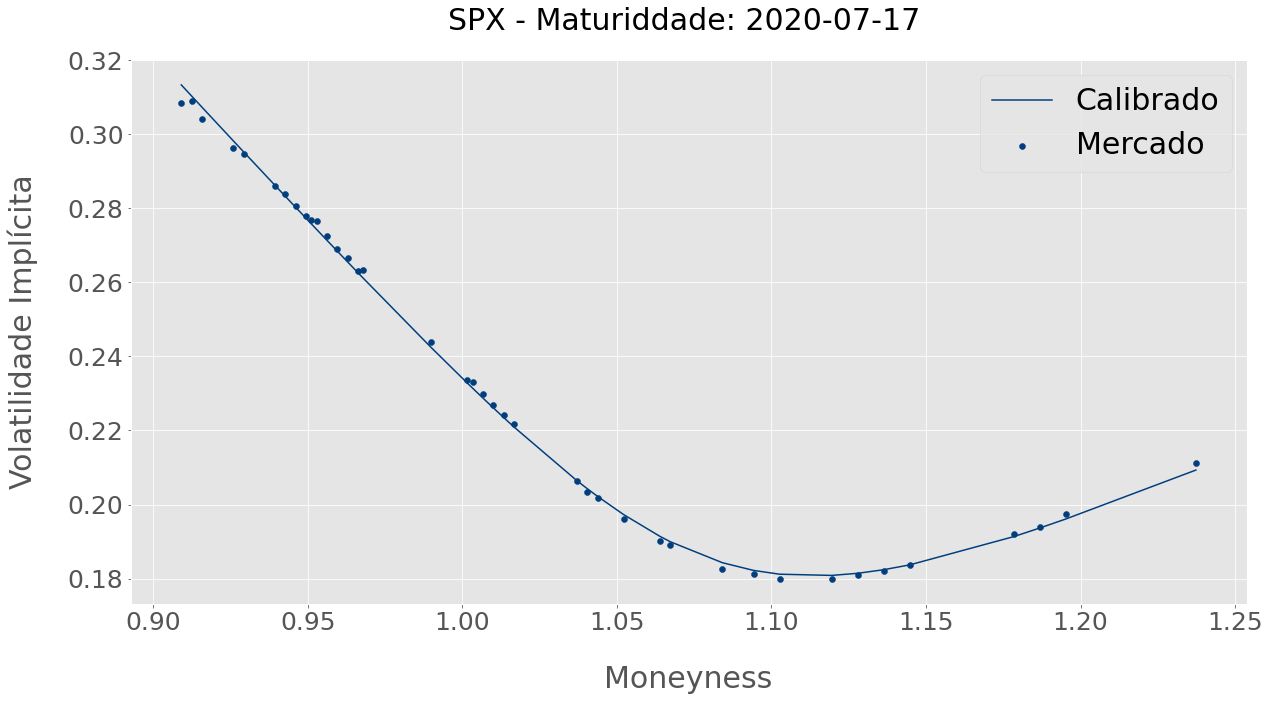

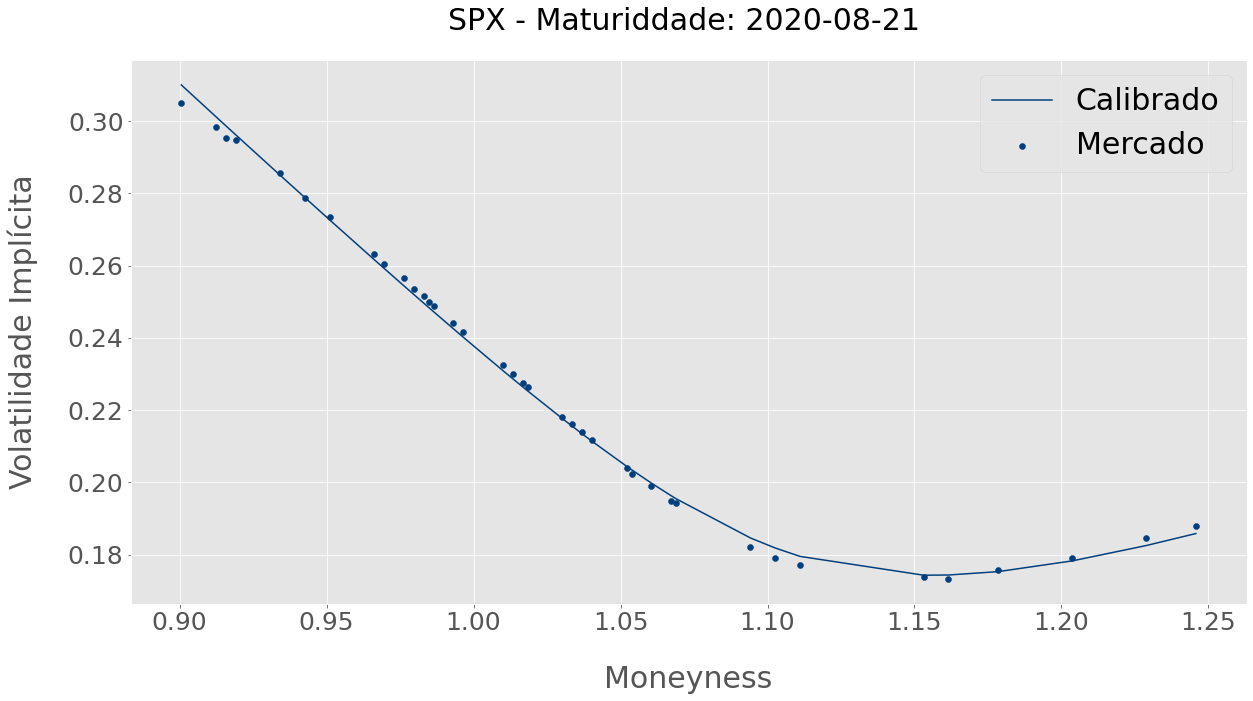

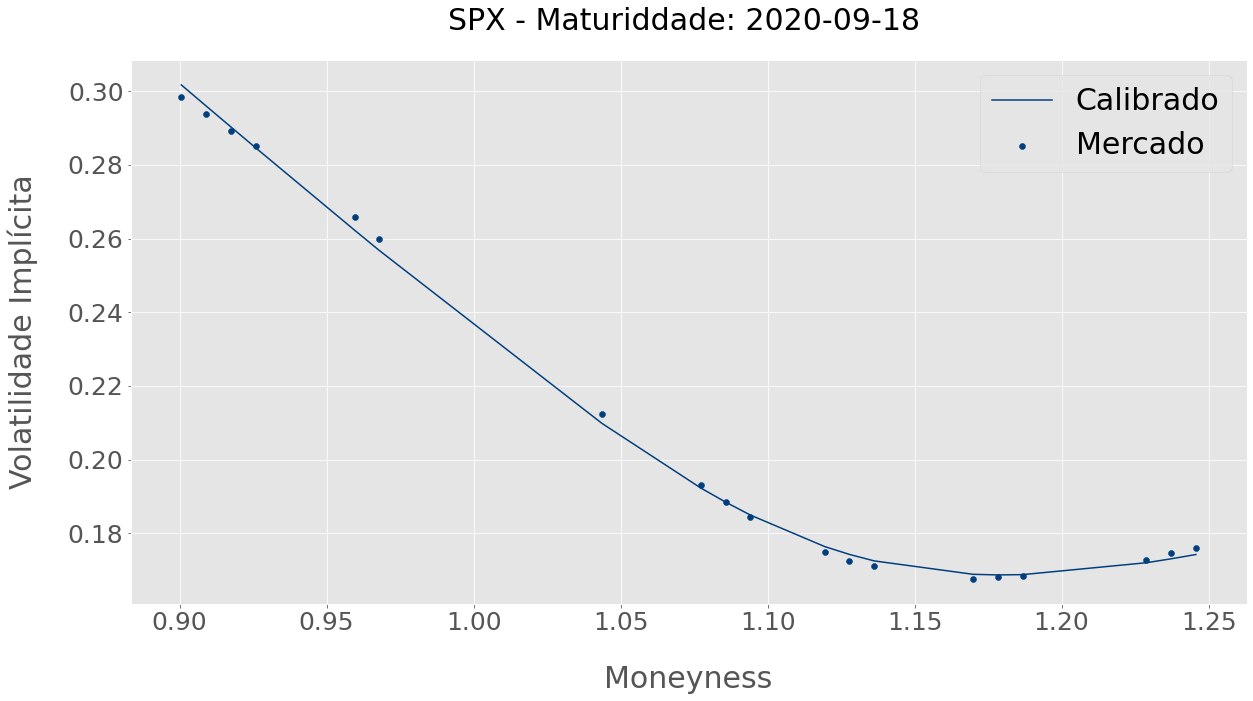

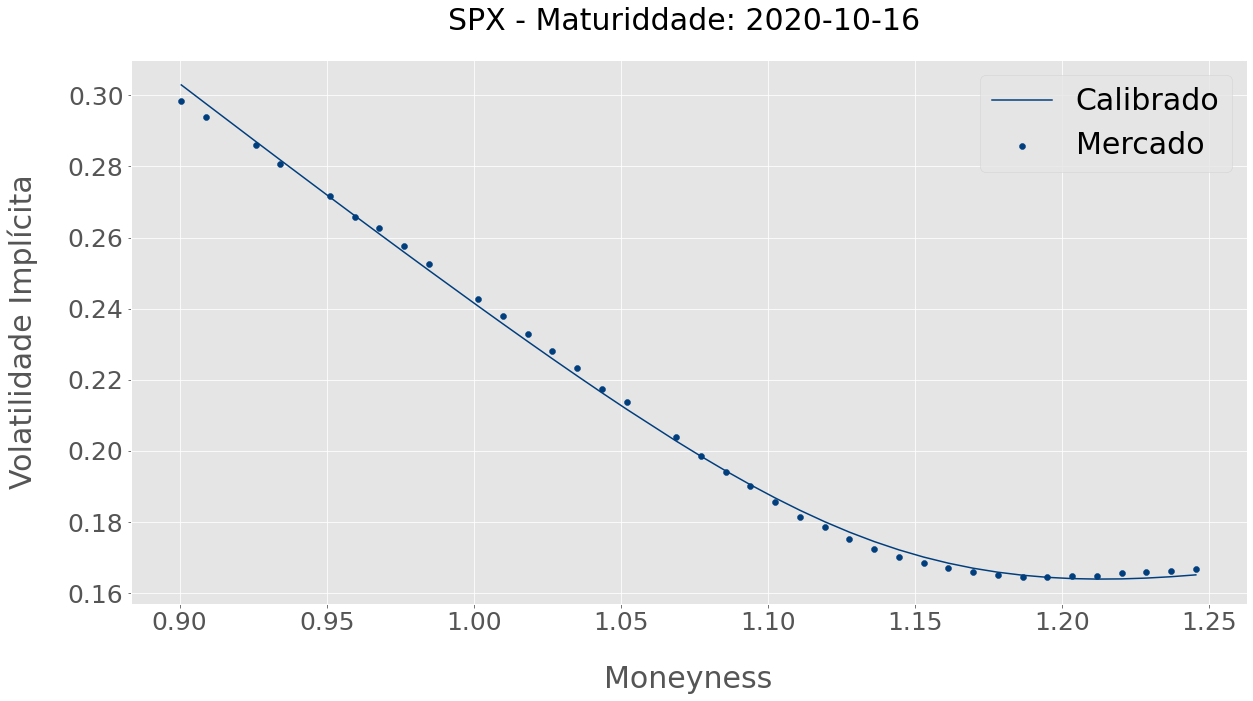

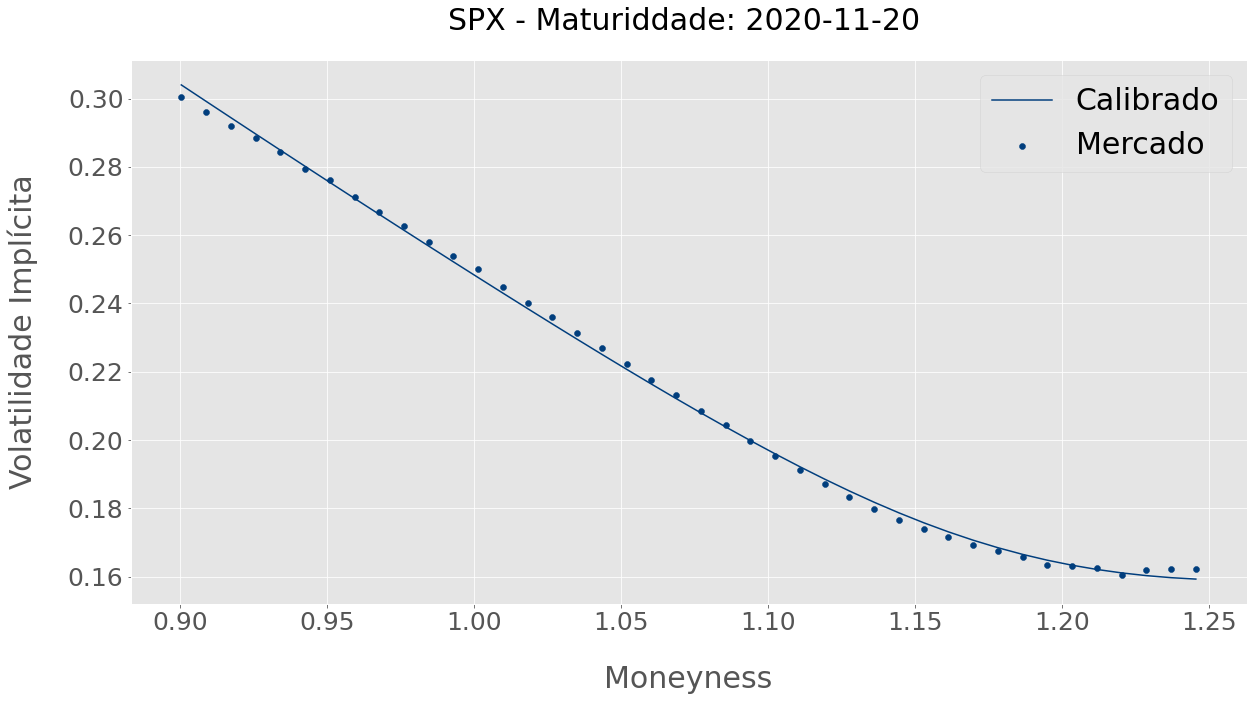

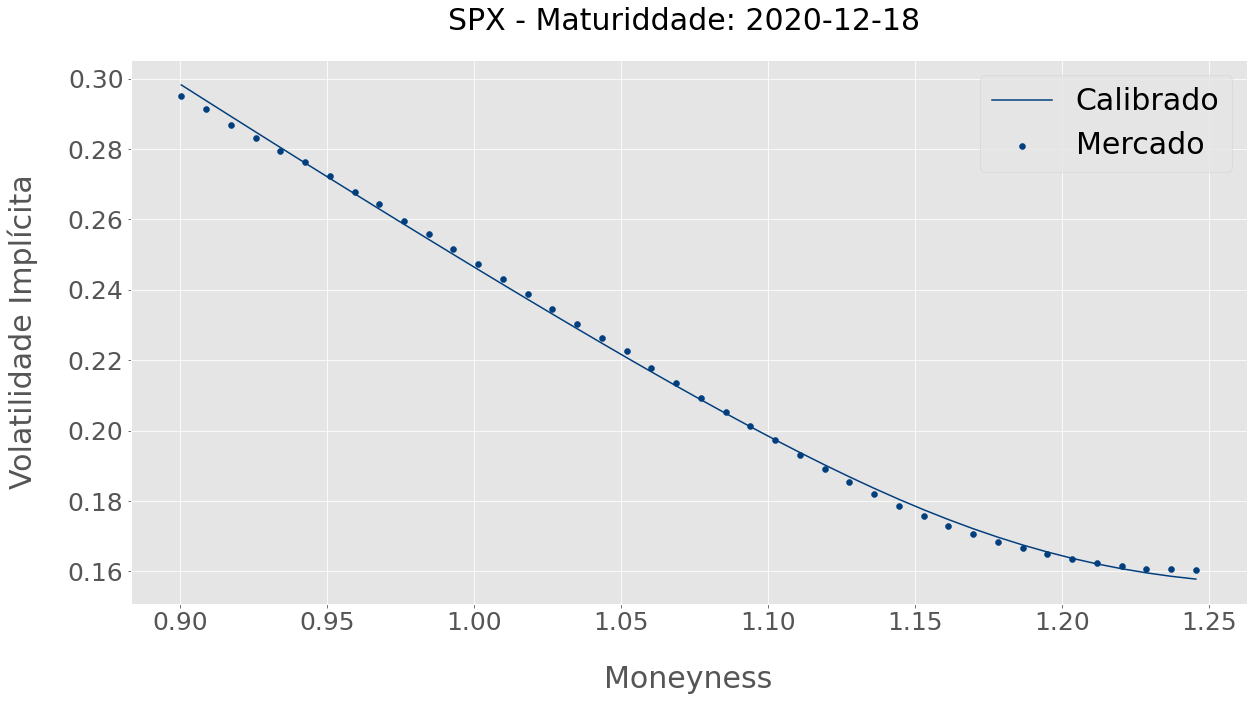

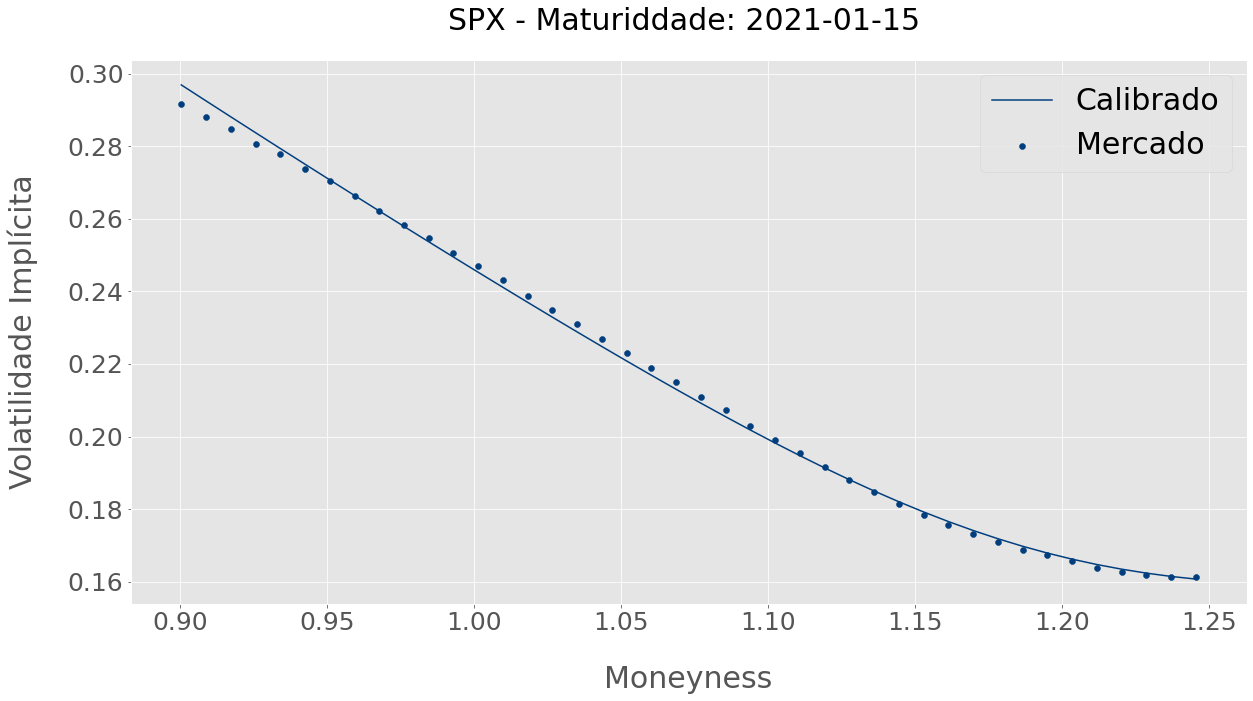

In [91]:
r = 0.0005
param0 = [0.4, -0.5, 0.04]
bounds = [(0.001,None), (-0.99,0.99), (0.001,None)]

unique_T = np.unique(option_data['Time to maturity'].values)

param_calibrated = {}

option_data['IV Calibrada'] = 0.0

for i in range(len(unique_T)):

    option_data_curve = option_data[option_data['Time to maturity'] == unique_T[i]]

    T = option_data_curve['Time to maturity'].values[0]
    S0 = option_data_curve['Underlying_Price'].values[0]
    K = option_data_curve['Strike'].values
    IV = option_data_curve['IV'].values
    
    res = minimize(loss, x0=param0, bounds=bounds)
    
    mat = str(option_data_curve['Expiry'].iloc[0])[:11]
    
    param_calibrated[mat] = {'xi': res.x[0], 'rho': res.x[1], 'sigma0': res.x[2]}
    
    IV_calibrated = SABRFormula(S0, T, K, r, param_calibrated[mat])
    m = option_data_curve['Moneyness'].values
    
    option_data.loc[option_data['Time to maturity'] == unique_T[i],'IV Calibrada'] = IV_calibrated
    
    param_calibrated[mat]['ttm'] = unique_T[i]

    fig, ax = plt.subplots(1,1)
    plt.title('SPX - Maturiddade: ' + mat, pad=30)
    ax.plot(m,  IV_calibrated, c=color_dark_blue, label='Calibrado')
    ax.scatter(m, IV, c=[color_dark_blue], label='Mercado')
    ax.set_xlabel('Moneyness')
    ax.set_ylabel('Volatilidade Implícita')
    plt.legend()
    ax.yaxis.labelpad=30
    ax.xaxis.labelpad=30
    
    param0 = list(param_calibrated[mat].values())[:-1]

In [92]:
pd.DataFrame.from_dict(param_calibrated)

,2020-07-17,2020-08-21,2020-09-18,2020-10-16,2020-11-20,2020-12-18,2021-01-15
xi,2.269643,1.834589,1.645876,1.509551,1.342389,1.245429,1.240956
rho,-0.714919,-0.761184,-0.781047,-0.815797,-0.848546,-0.853539,-0.842464
sigma0,0.233834,0.240560,0.240724,0.249353,0.259625,0.258621,0.258892
ttm,0.158333,0.255556,0.333333,0.411111,0.508333,0.586111,0.663889


In [93]:
from scipy.interpolate import PchipInterpolator

ttm = [x['ttm'] for x in list(param_calibrated.values())]
xi = [x['xi'] for x in list(param_calibrated.values())]
rho = [x['rho'] for x in list(param_calibrated.values())]
sigma0 = [x['sigma0'] for x in list(param_calibrated.values())]

xi_interp = PchipInterpolator(ttm, xi, extrapolate=True)
rho_interp = PchipInterpolator(ttm, rho, extrapolate=True)
sigma0_interp = PchipInterpolator(ttm, sigma0, extrapolate=True)

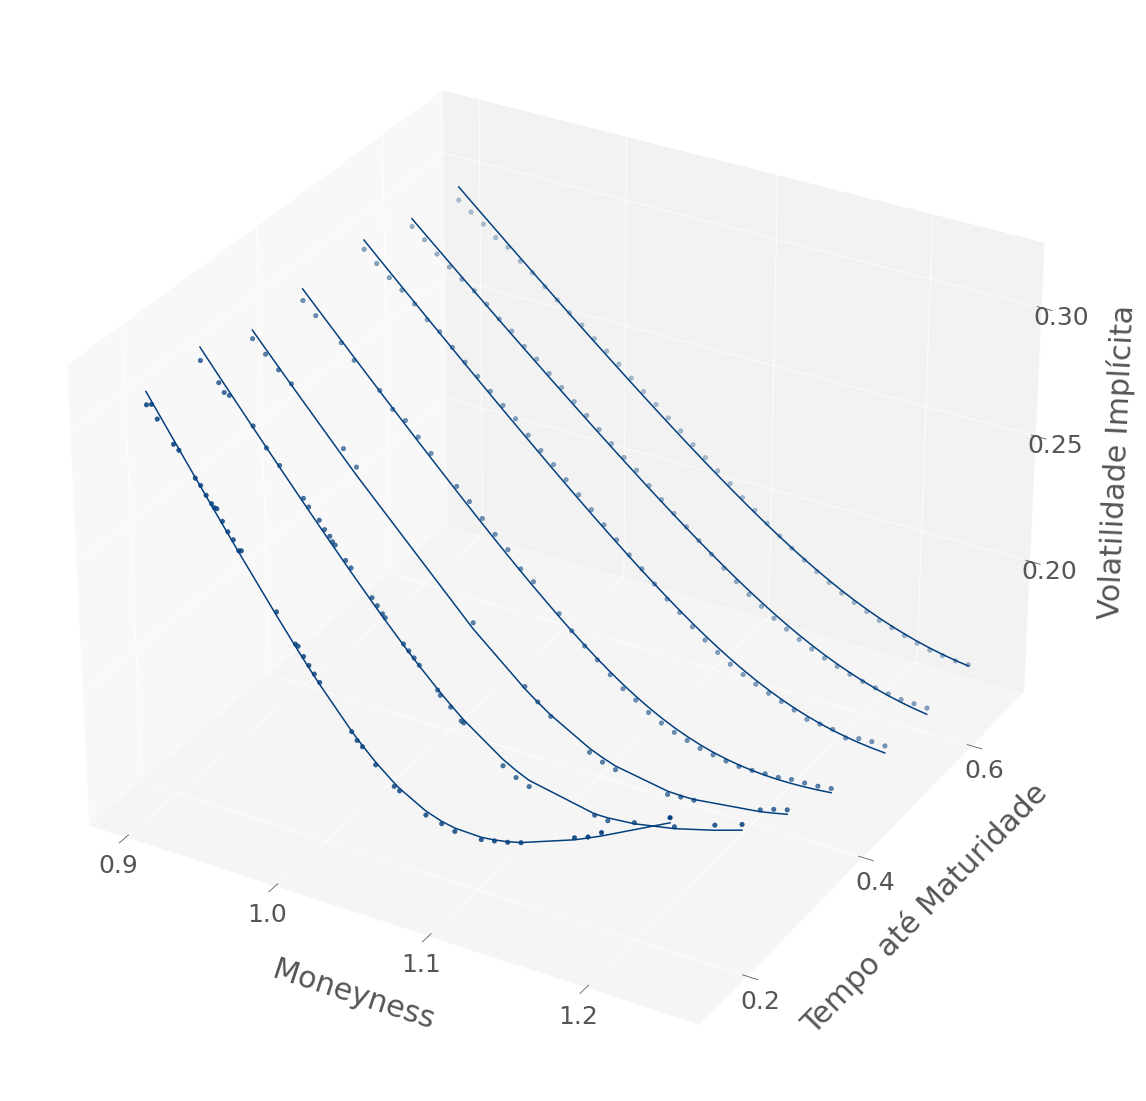

In [94]:
ax = plt.figure(figsize=(30,20)).add_subplot(projection='3d')
plt.locator_params(nbins=5)
ax.set_facecolor('white')
ax.scatter(option_data['Moneyness'].values, option_data['Time to maturity'].values, option_data['IV'].values, c=[color_dark_blue], label='Mercado')
ax.yaxis.labelpad=30
ax.xaxis.labelpad=30
ax.zaxis.labelpad=30
ax.set_xlabel('Moneyness')
ax.set_ylabel('Tempo até Maturidade')
ax.set_zlabel('Volatilidade Implícita')

for i in range(len(unique_T)):

    option_data_curve = option_data[option_data['Time to maturity'] == unique_T[i]]

    T = option_data_curve['Time to maturity'].values
    IV_calibrated = option_data_curve['IV Calibrada'].values
    m = option_data_curve['Moneyness'].values
    
    ax.plot(m, T, IV_calibrated, label='Calibrado', c=color_dark_blue)

# Densidade Neutra ao Risco

$C(T,K)$, para $T>0$ fixo, é duas vezes derivável em relação a $K$ se, e somente se, $S_{T}$ tiver
densidade sob a medida neutra ao risco. Nesse caso, se denotarmos a densidade de $S_{T}$ por $f_{T}$, vale a seguinte igualdade
$$
f_{T}(K) = e^{rT}\frac{\partial^{2} C}{\partial K^{2}}(T,K).
$$

In [95]:
from scipy.stats import norm
def BlackScholesFormula(S, T, K, sigma, r):
    
    d1 = (np.log(S/K) + (r + sigma**2/2)*T)/(sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    call_price = S * norm.cdf(d1) - K * np.exp(-r*T) * norm.cdf(d2)
    
    return call_price

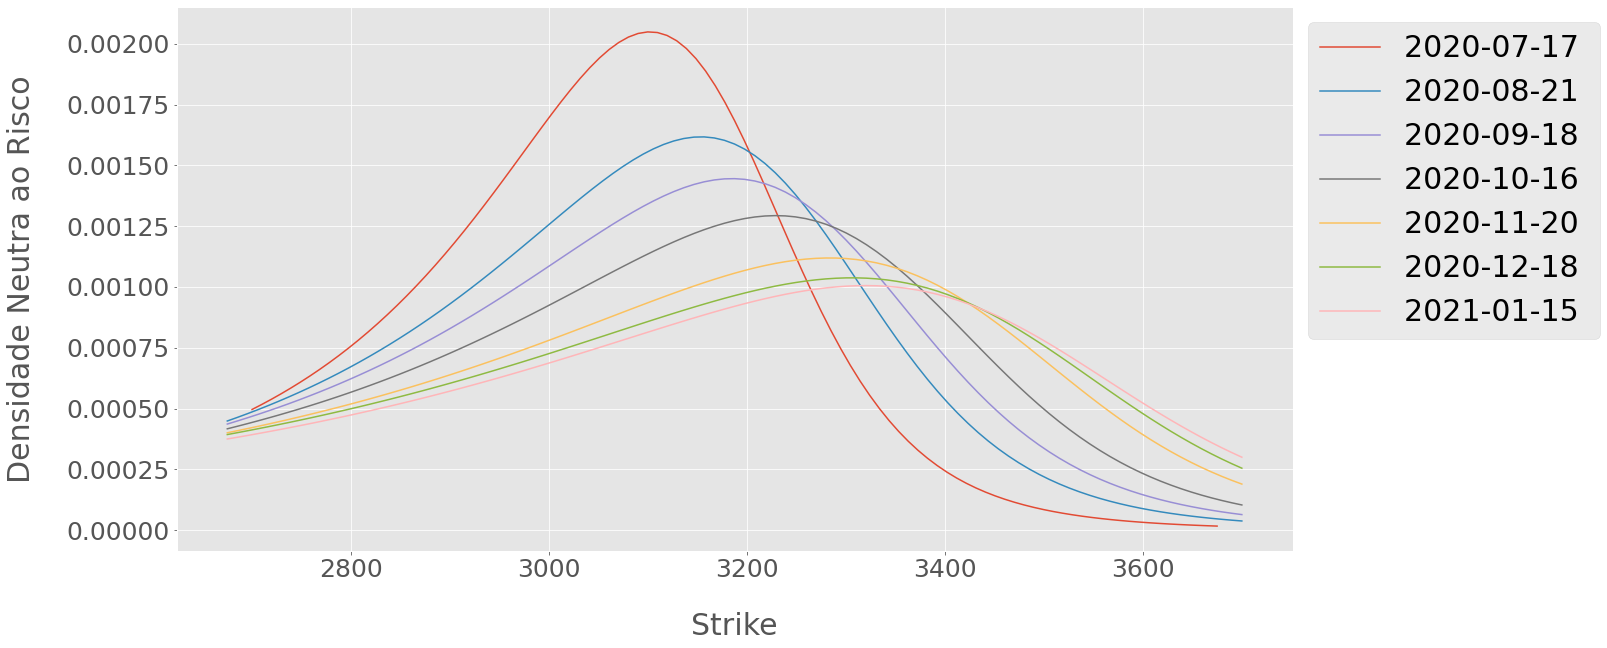

In [96]:
fig, ax = plt.subplots(1,1)
ax.set_xlabel('Strike')
ax.set_ylabel('Densidade Neutra ao Risco')
ax.yaxis.labelpad=30
ax.xaxis.labelpad=30

for i in range(len(unique_T)):

    option_data_curve = option_data[option_data['Time to maturity'] == unique_T[i]]

    T = option_data_curve['Time to maturity'].values[0]
    S0 = option_data_curve['Underlying_Price'].values[0]
    K = option_data_curve['Strike'].values
    
    mat = str(option_data_curve['Expiry'].iloc[0])[:11]
    
    K = np.linspace(K[0], K[-1], 101)
    dK = 1e-2
    
    IV_calibrated = SABRFormula(S0, T, K, r, param_calibrated[mat])
    IV_calibrated_plus_dK = SABRFormula(S0, T, K*(1 + dK), r, param_calibrated[mat])
    IV_calibrated_minus_dK = SABRFormula(S0, T, K*(1 - dK), r, param_calibrated[mat])
    
    C_calibrated = BlackScholesFormula(S0, T, K, IV_calibrated, r)
    C_calibrated_plus_dK = BlackScholesFormula(S0, T, K*(1 + dK), IV_calibrated_plus_dK, r)
    C_calibrated_minus_dK = BlackScholesFormula(S0, T, K*(1 - dK), IV_calibrated_minus_dK, r)
    
    d2C_calibrated_dK2 = (C_calibrated_plus_dK - 2*C_calibrated + C_calibrated_minus_dK)/(K*dK)**2
    
    density = np.exp(r*T) * d2C_calibrated_dK2
    
    ax.plot(K,  density, label=mat)
    
plt.legend(bbox_to_anchor=(1.0, 1.0))

# Volatilidade Local

A volatilidade local é dada por:
$$\sigma^{2}_L(T,K) = \frac{\frac{\partial \mathcal{C}}{\partial T}(T,K)
+ r K \frac{\partial \mathcal{C}}{\partial K}(T,K)}{ \frac{1}{2}K^{2}\frac{\partial^{2}
\mathcal{C}}{\partial K^{2}}(T,K)}$$

In [97]:
N = 101

local_vol = np.zeros((N, N))
strikes = np.zeros((N, N))
ttm_matrix = np.zeros((N, N))

T = np.linspace(ttm[0], ttm[-1], N)
K = np.linspace(np.min(option_data['Strike'].values), np.max(option_data['Strike'].values), N)

for i in range(N):
    
    strikes[i,:] = K
    ttm_matrix[i,:] = T[i]
    dK = 1e-2
    dT = 1e-2
    
    param_calibrated_interp = {'xi': xi_interp(T[i]), 'rho': rho_interp(T[i]), 
                               'sigma0': sigma0_interp(T[i])}
    
    IV_calibrated = SABRFormula(S0, T[i], K, r, param_calibrated_interp)
    IV_calibrated_plus_dK = SABRFormula(S0, T[i], K*(1 + dK), r, param_calibrated_interp)
    IV_calibrated_minus_dK = SABRFormula(S0, T[i], K*(1 - dK), r, param_calibrated_interp)
    
    C_calibrated = BlackScholesFormula(S0, T[i], K, IV_calibrated, r)
    C_calibrated_plus_dK = BlackScholesFormula(S0, T[i], K*(1 + dK), IV_calibrated_plus_dK, r)
    C_calibrated_minus_dK = BlackScholesFormula(S0, T[i], K*(1 - dK), IV_calibrated_minus_dK, r)
    
    dC_calibrated_dK = (C_calibrated_plus_dK - C_calibrated_minus_dK)/(2*K*dK)
    d2C_calibrated_dK2 = (C_calibrated_plus_dK - 2*C_calibrated + C_calibrated_minus_dK)/(K*dK)**2
    
    param_calibrated_interp_dT = {'xi': xi_interp(T[i]*(1 + dT)), 'rho': rho_interp(T[i]*(1 + dT)), 
                               'sigma0': sigma0_interp(T[i]*(1 + dT))}    
    IV_calibrated_dT = SABRFormula(S0, T[i]*(1 + dT), K, r, param_calibrated_interp_dT)
    C_calibrated_dT = BlackScholesFormula(S0, T[i]*(1 + dT), K, IV_calibrated_dT, r)
    dC_calibrated_dT = (C_calibrated_dT - C_calibrated)/(T[i]*dT)
    
    local_vol[i,:] = np.sqrt((dC_calibrated_dT + r*K*dC_calibrated_dK)/(0.5 * K**2 * d2C_calibrated_dK2))

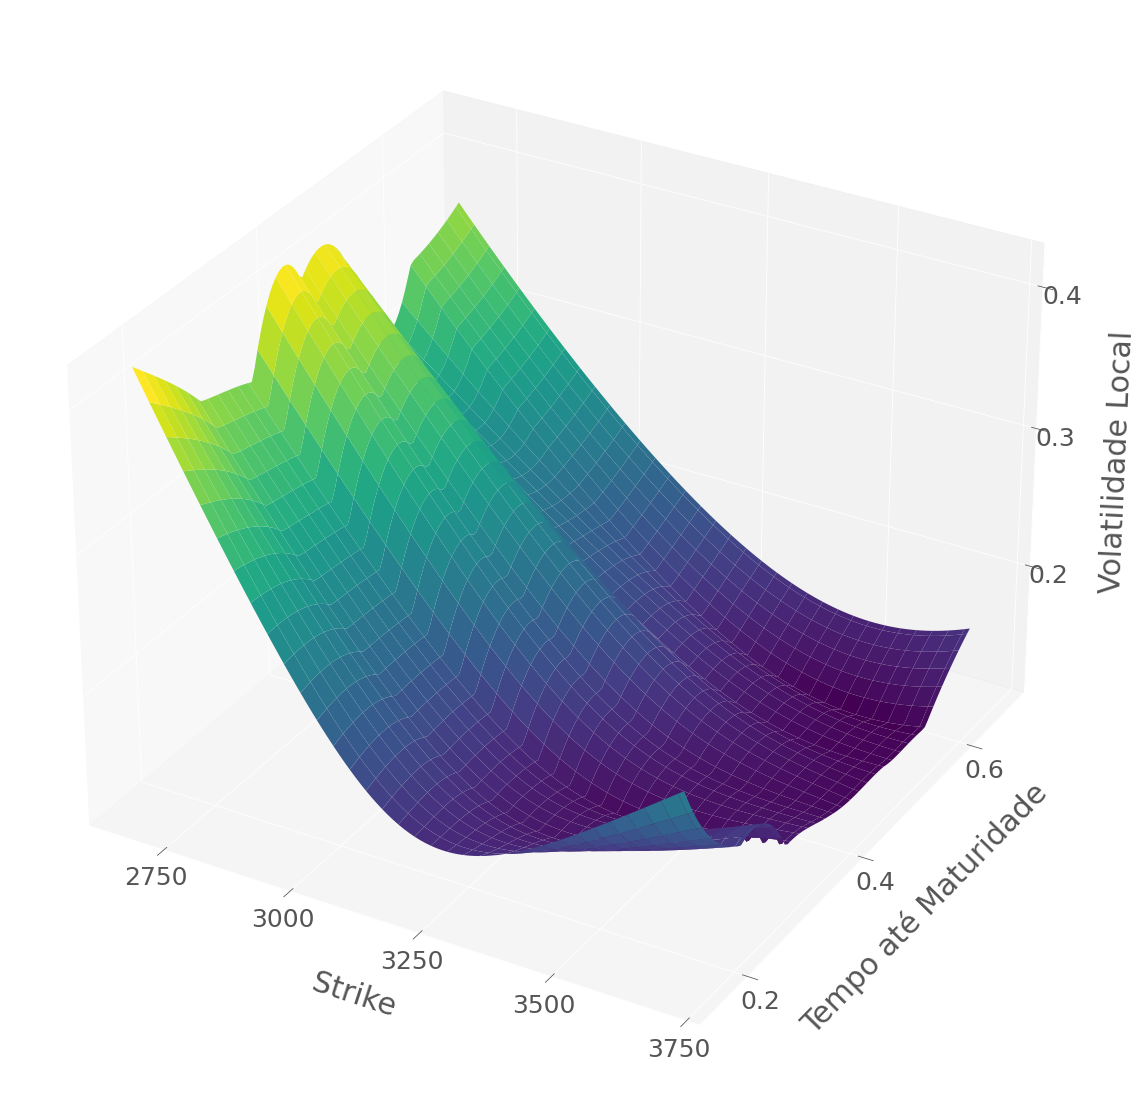

In [99]:
from matplotlib import cm
ax = plt.figure(figsize=(30,20)).add_subplot(projection='3d')
plt.locator_params(nbins=5)
ax.set_facecolor('white')
ax.yaxis.labelpad=30
ax.xaxis.labelpad=30
ax.zaxis.labelpad=30
ax.set_xlabel('Strike')
ax.set_ylabel('Tempo até Maturidade')
ax.set_zlabel('Volatilidade Local')
ax.plot_surface(strikes, ttm_matrix, local_vol, cmap=cm.viridis)